<a href="https://colab.research.google.com/github/gabrie1-s/phosphorus_analysis/blob/main/Analise_fosforo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Importing libraries and reading data

In [1]:
%%capture
!pip install Bayesian-Optimization
!pip install xgboost
!pip install ray

In [2]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statistics
import math
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
import os
import gc
import pdb
import ray
import keras
import xgboost
import tensorflow
from scipy import stats
from sklearn import metrics
from xgboost import XGBRegressor
from keras.models import load_model
from bayes_opt import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go

In [4]:
ray.init()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-07 16:55:40,529	INFO worker.py:1753 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.24.0


In [5]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
fosforo = pd.read_excel("/content/drive/MyDrive/CNN_Chagas/fosforo/Dados_B1_B7.xlsx")

In [7]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [8]:
fosforo.columns = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'P']

In [9]:
dataset = fosforo[fosforo.columns[:7]]

In [10]:
target = fosforo['P']

# 2. Histograms / Skew

In [11]:
df = dataset.copy()
df['P'] = target

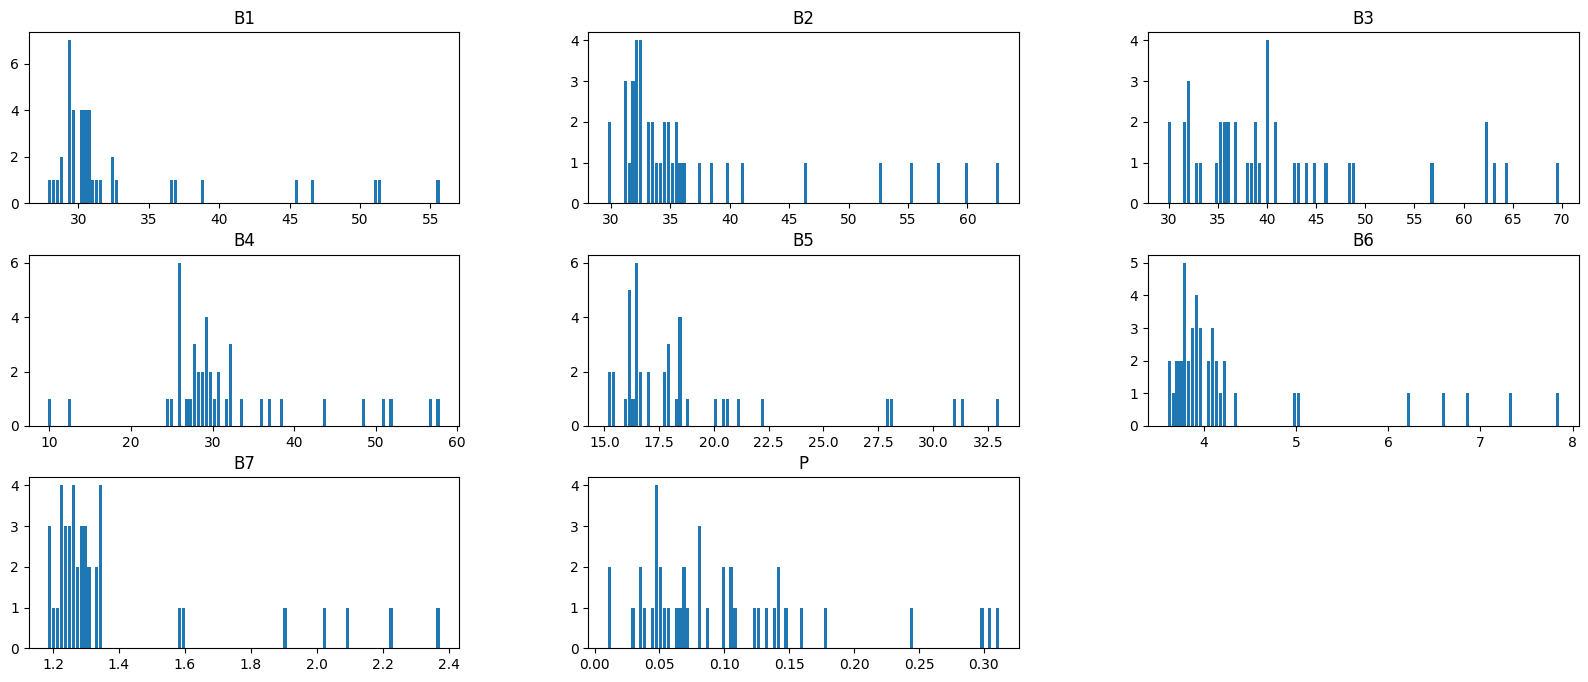

In [12]:
df.hist(
    figsize=(20, 8),
    grid = False,
    rwidth = 0.8,
    bins = 100
)
plt.show()

In [13]:
df.skew()

B1    2.202681
B2    2.021795
B3    1.406842
B4    0.991740
B5    2.011601
B6    2.300812
B7    2.306189
P     1.565691
dtype: float64

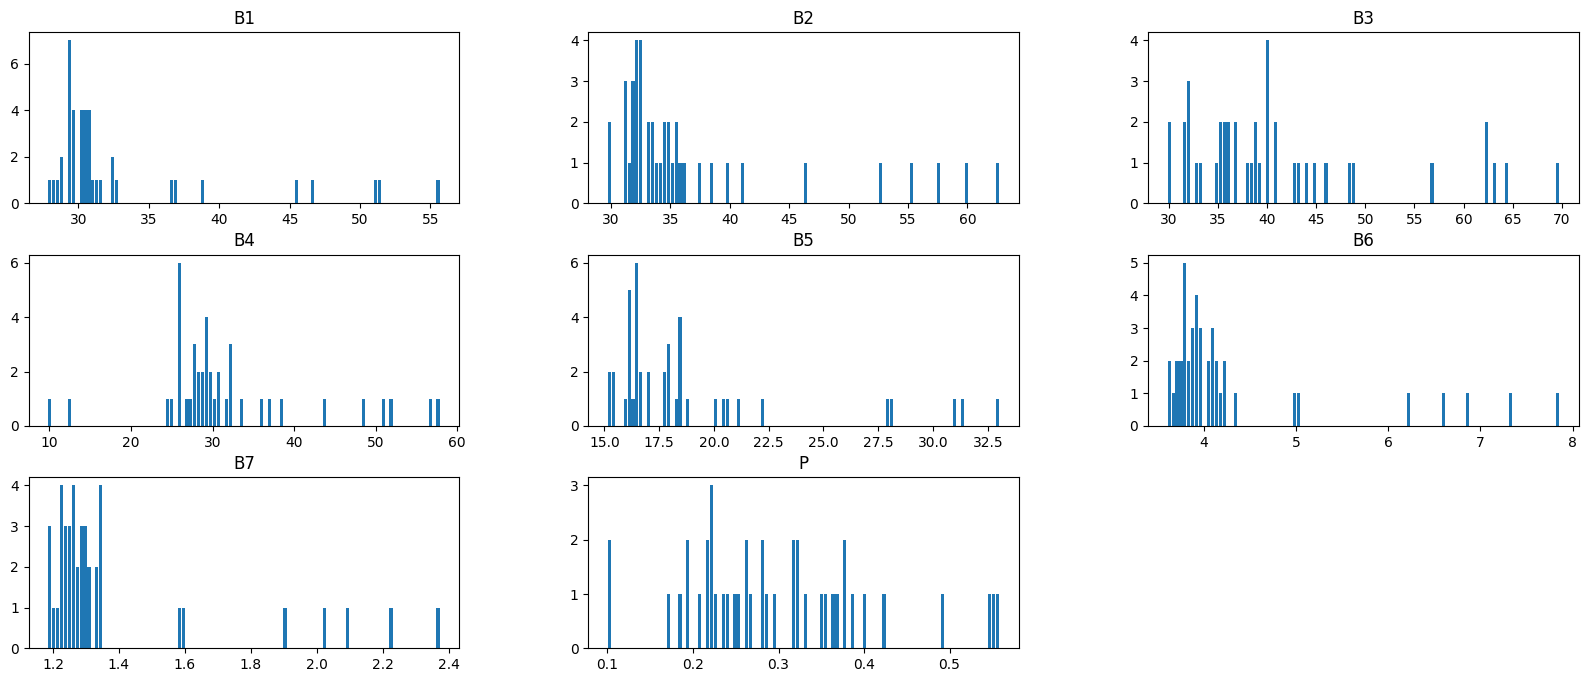

In [14]:
lbs = []

for col in df.columns:
  if abs(df.skew()[col]) > 0.9:
    _, l = stats.boxcox(df[col])[0:2]
    lbs.append(l)

target = np.sqrt(target)
df['P'] = target

df.hist(
    figsize=(20, 8),
    grid = False,
    rwidth = 0.8,
    bins = 100
)
plt.show()

In [15]:
lbs

[-6.756821209151582,
 -4.911524211710275,
 -2.1109315692577852,
 0.4495494212091018,
 -4.232461187722476,
 -5.997571733575384,
 -7.043710808407542,
 0.199055449196808]

In [16]:
df.skew()

B1    2.202681
B2    2.021795
B3    1.406842
B4    0.991740
B5    2.011601
B6    2.300812
B7    2.306189
P     0.712777
dtype: float64

In [17]:
dataset = df[df.columns[:7]]
target = df['P']

# 3. Boxplots

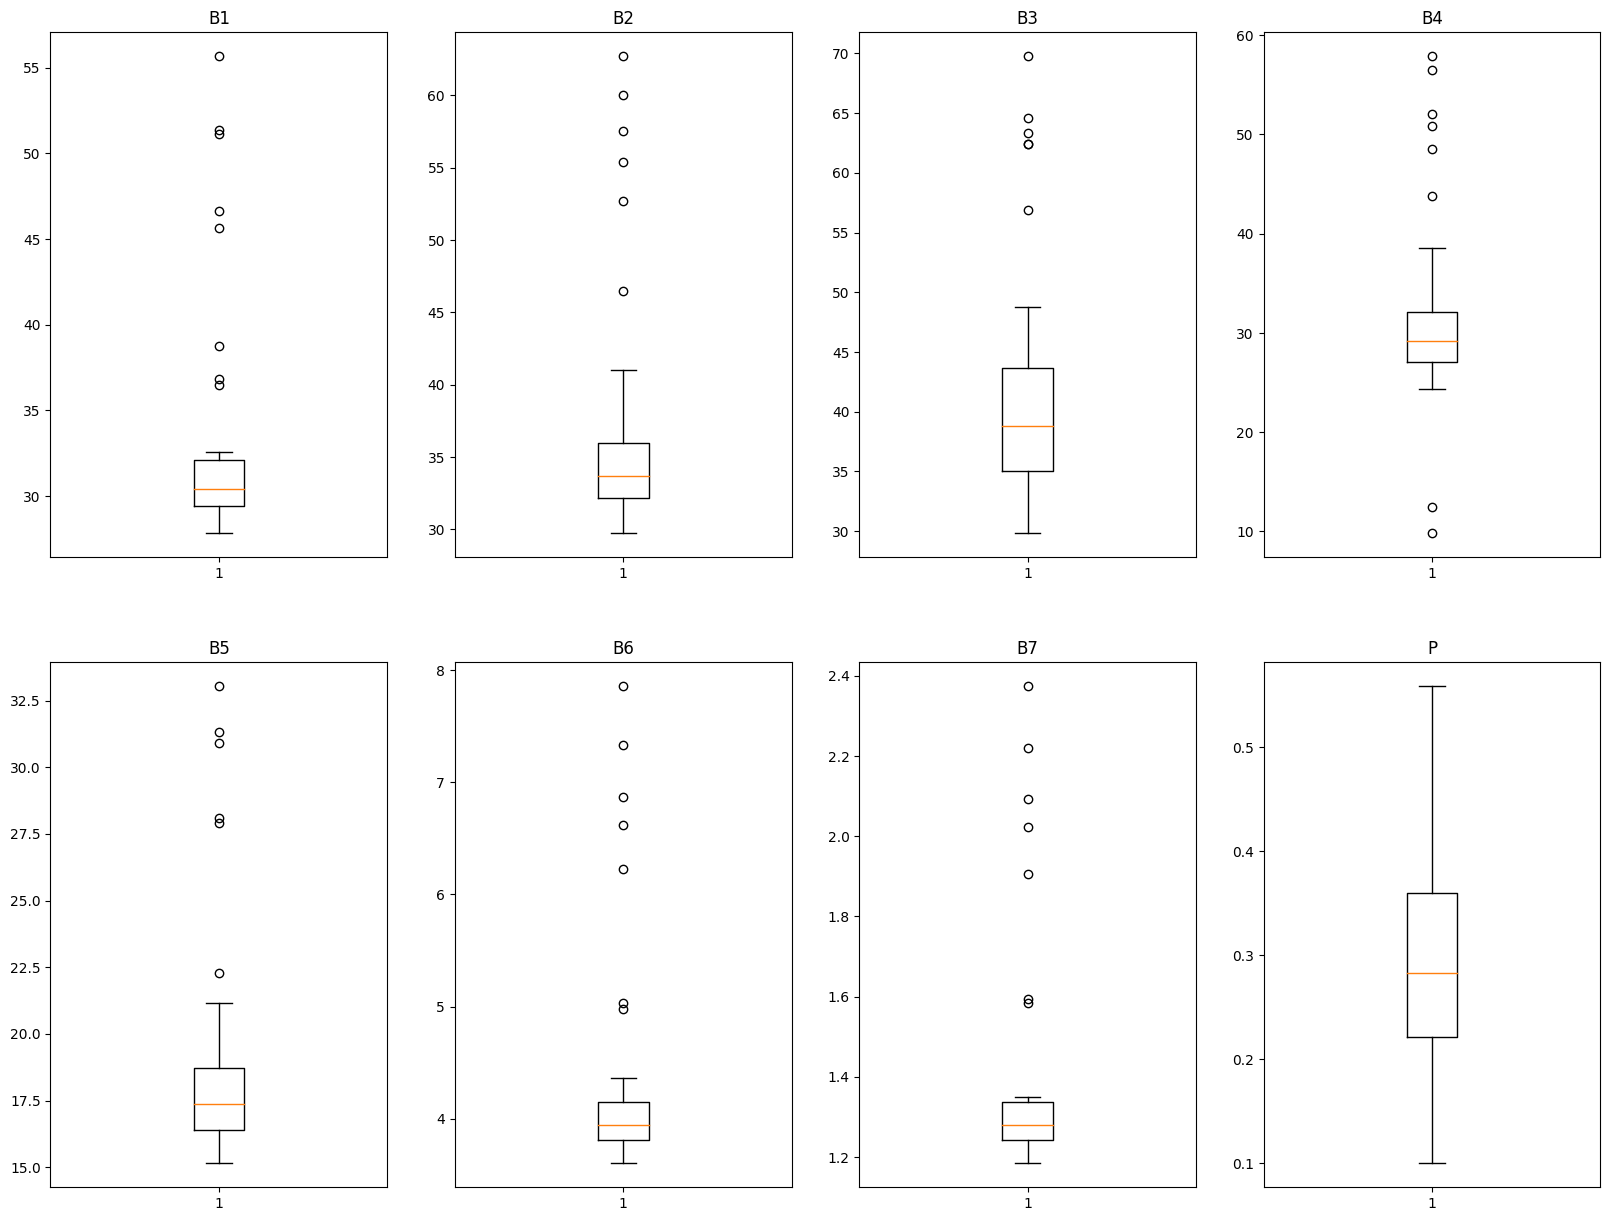

In [18]:
i=0
j=0

df = dataset.copy()
df['P'] = target

plt.rcParams["figure.figsize"] = (20,15)
fig, axs = plt.subplots(2, 4)
for col in df.columns:
  axs[i,j].set_title(col)
  axs[i,j].boxplot(df[col])
  j +=1

  if j > 3:
    j = 0
    i +=1

plt.show()

# 4. Outliers Removal

In [19]:
def outliers_treatment(dataset, target, method='remotion', median_p_dist=0.1, target_dist=0.1):
  if method == 'median':
    for i, p1 in enumerate(target):
      similar = [i]
      for j, p2 in enumerate(target):
        if abs(p1-p2) < target_dist*p1:
          similar.append(j)

      for k in range(len(dataset.columns)):
        for j in similar:
          if abs(dataset.iloc[i, k] - dataset.iloc[j, k]) > median_p_dist*dataset.iloc[i, k]:
            dataset.iloc[i, k] = statistics.median([dataset.iloc[c, k] for c in similar])
            dataset.iloc[j, k] = statistics.median([dataset.iloc[c, k] for c in similar])


  elif method == 'remotion':
    to_drop = []
    for i, p1 in enumerate(target):
      similar = [i]
      for j, p2 in enumerate(target):
        if abs(p1-p2) < target_dist*p1:
          similar.append(j)

      for k in range(len(dataset.columns)):
        if abs(dataset.iloc[i, k] - statistics.median([dataset.iloc[c, k] for c in similar])) >  median_p_dist*dataset.iloc[i, k]:
          to_drop.append(i)
          break

    dataset = dataset.drop(index=to_drop)
    dataset.reset_index(drop=True, inplace=True)
    target = target.drop(index=to_drop)
    target.reset_index(drop=True, inplace=True)

  return dataset, target


In [19]:
to_drop = [val for val in target.index if target[val] > 0.4]
dataset = dataset.drop(index=to_drop)
dataset.reset_index(drop=True, inplace=True)
target = target.drop(index=to_drop)
target.reset_index(drop=True, inplace=True)

In [ ]:
dataset, target = outliers_treatment(dataset, target, method='remotion', median_p_dist=0.15)

In [20]:
dataset

,B1,B2,B3,B4,B5,B6,B7
0,30.1162,33.4923,38.7866,28.9411,17.8240,3.8617,1.2464
1,30.6845,34.1537,38.8822,30.0438,18.4973,3.9169,1.2551
2,45.6215,52.6813,62.4212,48.5056,28.0955,6.6208,2.0224
3,30.6840,32.1027,32.9215,25.8750,16.4034,3.8543,1.2500
4,29.3897,31.5916,33.0158,27.0334,16.5559,3.9747,1.2844
5,28.7015,29.9586,29.8104,24.3255,15.1438,3.6037,1.1841
6,30.1640,32.1973,32.1590,25.7599,16.1637,3.8129,1.2419
7,30.0888,31.7055,31.7910,25.7599,16.1637,3.8129,1.2419
8,29.2660,31.2224,32.1123,26.0156,16.0711,3.8806,1.2598
9,32.5785,35.2413,38.0632,29.1410,18.7888,4.0355,1.3000


In [21]:
target

0     0.375690
1     0.375500
2     0.324037
3     0.100000
4     0.100000
5     0.260768
6     0.221359
7     0.219089
8     0.225832
9     0.264575
10    0.219089
11    0.282843
12    0.293825
13    0.254296
14    0.250998
15    0.384708
16    0.221359
17    0.187083
18    0.361939
19    0.240832
20    0.234521
21    0.192354
22    0.223607
23    0.170294
24    0.370585
25    0.400000
26    0.353553
27    0.324037
28    0.316228
29    0.350714
30    0.284605
31    0.330151
32    0.194936
33    0.268328
34    0.209762
35    0.316228
36    0.282843
Name: P, dtype: float64

# 5. Polynomial Relations

In [22]:
for i in dataset.columns:
  dataset['ln('+str(i)+')'] = np.log(dataset[i])

for i in dataset.columns:
  dataset['1/' + str(i)] = 1/dataset[i]

In [23]:
dataset

,B1,B2,B3,B4,B5,B6,B7,ln(B1),ln(B2),ln(B3),ln(B4),ln(B5),ln(B6),ln(B7),1/B1,1/B2,1/B3,1/B4,1/B5,1/B6,1/B7,1/ln(B1),1/ln(B2),1/ln(B3),1/ln(B4),1/ln(B5),1/ln(B6),1/ln(B7)
0,30.1162,33.4923,38.7866,28.9411,17.8240,3.8617,1.2464,3.405063,3.511316,3.658075,3.365263,2.880546,1.351108,0.220259,0.033205,0.029858,0.025782,0.034553,0.056104,0.258953,0.802311,0.293680,0.284794,0.273368,0.297154,0.347156,0.740134,4.540101
1,30.6845,34.1537,38.8822,30.0438,18.4973,3.9169,1.2551,3.423758,3.530871,3.660537,3.402656,2.917625,1.365301,0.227215,0.032590,0.029279,0.025719,0.033285,0.054062,0.255304,0.796749,0.292077,0.283216,0.273184,0.293888,0.342745,0.732439,4.401113
2,45.6215,52.6813,62.4212,48.5056,28.0955,6.6208,2.0224,3.820379,3.964261,4.133905,3.881679,3.335609,1.890216,0.704285,0.021919,0.018982,0.016020,0.020616,0.035593,0.151039,0.494462,0.261754,0.252254,0.241902,0.257620,0.299795,0.529040,1.419880
3,30.6840,32.1027,32.9215,25.8750,16.4034,3.8543,1.2500,3.423741,3.468940,3.494126,3.253277,2.797489,1.349189,0.223144,0.032590,0.031150,0.030375,0.038647,0.060963,0.259450,0.800000,0.292078,0.288272,0.286195,0.307382,0.357463,0.741186,4.481420
4,29.3897,31.5916,33.0158,27.0334,16.5559,3.9747,1.2844,3.380644,3.452891,3.496986,3.297073,2.806743,1.379949,0.250292,0.034026,0.031654,0.030289,0.036991,0.060401,0.251591,0.778574,0.295802,0.289612,0.285961,0.303299,0.356285,0.724664,3.995339
5,28.7015,29.9586,29.8104,24.3255,15.1438,3.6037,1.1841,3.356949,3.399816,3.394857,3.191525,2.717591,1.281961,0.168983,0.034841,0.033379,0.033545,0.041109,0.066034,0.277493,0.844523,0.297890,0.294134,0.294563,0.313330,0.367973,0.780055,5.917755
6,30.1640,32.1973,32.1590,25.7599,16.1637,3.8129,1.2419,3.406649,3.471883,3.470692,3.248819,2.782768,1.338390,0.216642,0.033152,0.031059,0.031095,0.038820,0.061867,0.262268,0.805218,0.293544,0.288028,0.288127,0.307804,0.359354,0.747166,4.615900
7,30.0888,31.7055,31.7910,25.7599,16.1637,3.8129,1.2419,3.404153,3.456490,3.459183,3.248819,2.782768,1.338390,0.216642,0.033235,0.031540,0.031455,0.038820,0.061867,0.262268,0.805218,0.293759,0.289311,0.289086,0.307804,0.359354,0.747166,4.615900
8,29.2660,31.2224,32.1123,26.0156,16.0711,3.8806,1.2598,3.376426,3.441136,3.469239,3.258696,2.777023,1.355990,0.230953,0.034169,0.032028,0.031141,0.038438,0.062223,0.257692,0.793777,0.296171,0.290602,0.288248,0.306871,0.360098,0.737469,4.329886
9,32.5785,35.2413,38.0632,29.1410,18.7888,4.0355,1.3000,3.483653,3.562219,3.639248,3.372146,2.933261,1.395130,0.262364,0.030695,0.028376,0.026272,0.034316,0.053223,0.247801,0.769231,0.287055,0.280724,0.274782,0.296547,0.340918,0.716779,3.811495


In [24]:
poly = PolynomialFeatures(degree=7, include_bias=False)
poly_features = poly.fit_transform(dataset)
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(dataset.columns))

# 6. Selection by Correlation

In [25]:
def one_side_corr(data, target, method='spearman', target_corr=0.5, variables_corr=0.5):
    other_columns = [col for col in data.columns if col != target]
    values = []
    accepted_cols = []
    accepted_values = []
    for col in other_columns:
      corr_value = data[target].corr(data[col], method=method)
      if corr_value > target_corr:
        values.append((col, corr_value))

    values = sorted(values, key=lambda x: x[1], reverse=True)
    accepted_cols.append(values[0][0])
    accepted_values.append(values[0])

    for i in values:
      count = 0
      for col_acc in accepted_cols:
        if abs(data[col_acc].corr(data[i[0]], method=method)) > variables_corr:
          count += 1
          break
      if count == 0:
        accepted_cols.append(i[0])
        accepted_values.append(i)

    return accepted_values

In [26]:
poly_df['P'] = target
poly_corr = one_side_corr(poly_df, 'P',method="spearman", target_corr=0.5, variables_corr=0.7)

In [27]:
poly_corr

[('B2 ln(B2)^2 ln(B6) 1/B1 1/B7 1/ln(B3)', 0.7412546419479165),
 ('B5 B6 B7^2 ln(B3) 1/B1 1/ln(B7)', 0.680540775898111),
 ('ln(B5)^4 ln(B6) 1/B1 1/B6', 0.6695126713226581),
 ('B2 B5 B6 1/B1 1/B7 1/ln(B6)^2', 0.6499466793339514),
 ('ln(B2)^2 ln(B5) ln(B6) 1/B7 1/ln(B1) 1/ln(B3)', 0.6358354487481568),
 ('B6 ln(B1) ln(B3) ln(B6) 1/B7^2 1/ln(B4)', 0.6109332771261664),
 ('ln(B2) ln(B6)^3 1/B7^2 1/ln(B4)', 0.5614846791910709),
 ('B4 B6 ln(B5) 1/B7^2 1/ln(B3)^2', 0.5536582823955882),
 ('B2 B6^2 1/B1 1/B7^2 1/ln(B3)', 0.552472464699303),
 ('B2^2 ln(B5) 1/B1^2 1/ln(B3) 1/ln(B4)', 0.5473734486052764),
 ('B5^2 ln(B4) 1/B4 1/B7 1/ln(B1)', 0.5352781081031667),
 ('B3 B7 ln(B2) 1/B1 1/ln(B1) 1/ln(B4) 1/ln(B6)', 0.5218783681351432),
 ('B2 ln(B2)^2 1/ln(B1) 1/ln(B3) 1/ln(B6)', 0.5150006254966887),
 ('B5 ln(B6)^2 1/B7^2 1/ln(B1) 1/ln(B3)', 0.5102573547115477),
 ('B2 ln(B2)^2 1/B1 1/ln(B4)^2', 0.5019566308375508)]

In [28]:
poly_df = poly_df[[x[0] for x in poly_corr]]

In [29]:
y = target
x = poly_df

# 7.PCA

In [ ]:
# scaler = StandardScaler()
# x_scaled = scaler.fit_transform(x)
pca = PCA()
x_pca = pca.fit_transform(poly_df)

In [ ]:
cumulative_variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

val = list(range(1, len(cumulative_variance)+1))
fig = go.Figure(data=go.Scatter(x = val, y = cumulative_variance, mode='lines+markers'))
fig.update_layout(
    xaxis=dict(title='PCs', dtick=10 ,showgrid=True),
    yaxis=dict(title='Cumulative variance',  dtick=10, showgrid=True)
)
fig.show()

In [ ]:
x = pd.DataFrame()
y = target

for i, val in enumerate(np.transpose(x_pca[:, :41])[0:]):
  x['pc_' + str(i+1)] = val

# 8. Train/Test Split

In [30]:
from sklearn.model_selection import StratifiedKFold, KFold

In [31]:
def fold_visualizer(data, fold_idxs, seed_num):
    fig, axs = plt.subplots(len(fold_idxs)//2, 2, figsize=(15,(len(fold_idxs)//2)*5))
    fig.suptitle("Seed: " + str(seed_num), fontsize=16)
    for fold_id, (train_ids, val_ids) in enumerate(fold_idxs):
        sns.histplot(data=data[train_ids],
                     kde=True,
                     stat="density",
                     alpha=0.15,
                     label="Train Set",
                     bins=10,
                     line_kws={"linewidth":4},
                     ax=axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)])
        sns.histplot(data=data[val_ids],
                     kde=True,
                     stat="density",
                     color="darkorange",
                     alpha=0.15,
                     label="Validation Set",
                     bins=10,
                     line_kws={"linewidth":4},
                     ax=axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)])
        axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)].legend()
        axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)].set_title("Split " + str(fold_id+1))
    plt.show()

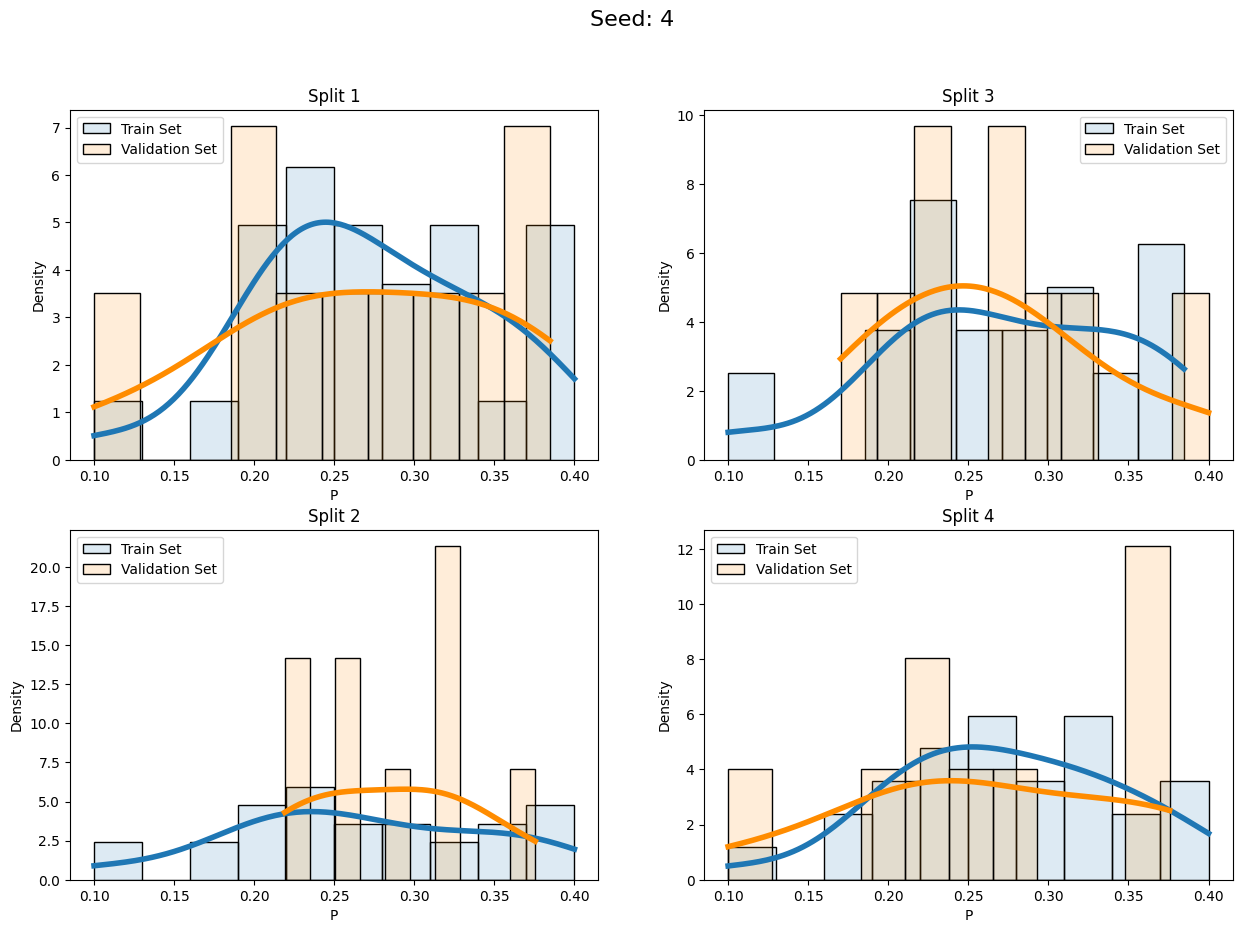

In [32]:
plt.rcParams["figure.figsize"] = (8,5)


baseline_kfold = list(KFold(4,
                            shuffle=True,
                            random_state=3
                            ).split(target))
fold_visualizer(data=target,
                fold_idxs=baseline_kfold,
                seed_num=4)

In [33]:
def create_cont_folds(df, n_s=8, n_grp=10, seed=1):

    skf = StratifiedKFold(n_splits=n_s, shuffle=True, random_state=seed)
    grp = pd.cut(df, n_grp, labels=False)
    target = grp

    fold_nums = np.zeros(len(df))
    for fold_no, (t, v) in enumerate(skf.split(target, target)):
        fold_nums[v] = fold_no

    cv_splits = []

    for i in range(n_s):
        test_indices = np.argwhere(fold_nums==i).flatten()
        train_indices = list(set(range(len(df))) - set(test_indices))
        cv_splits.append((train_indices, test_indices))

    return cv_splits

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


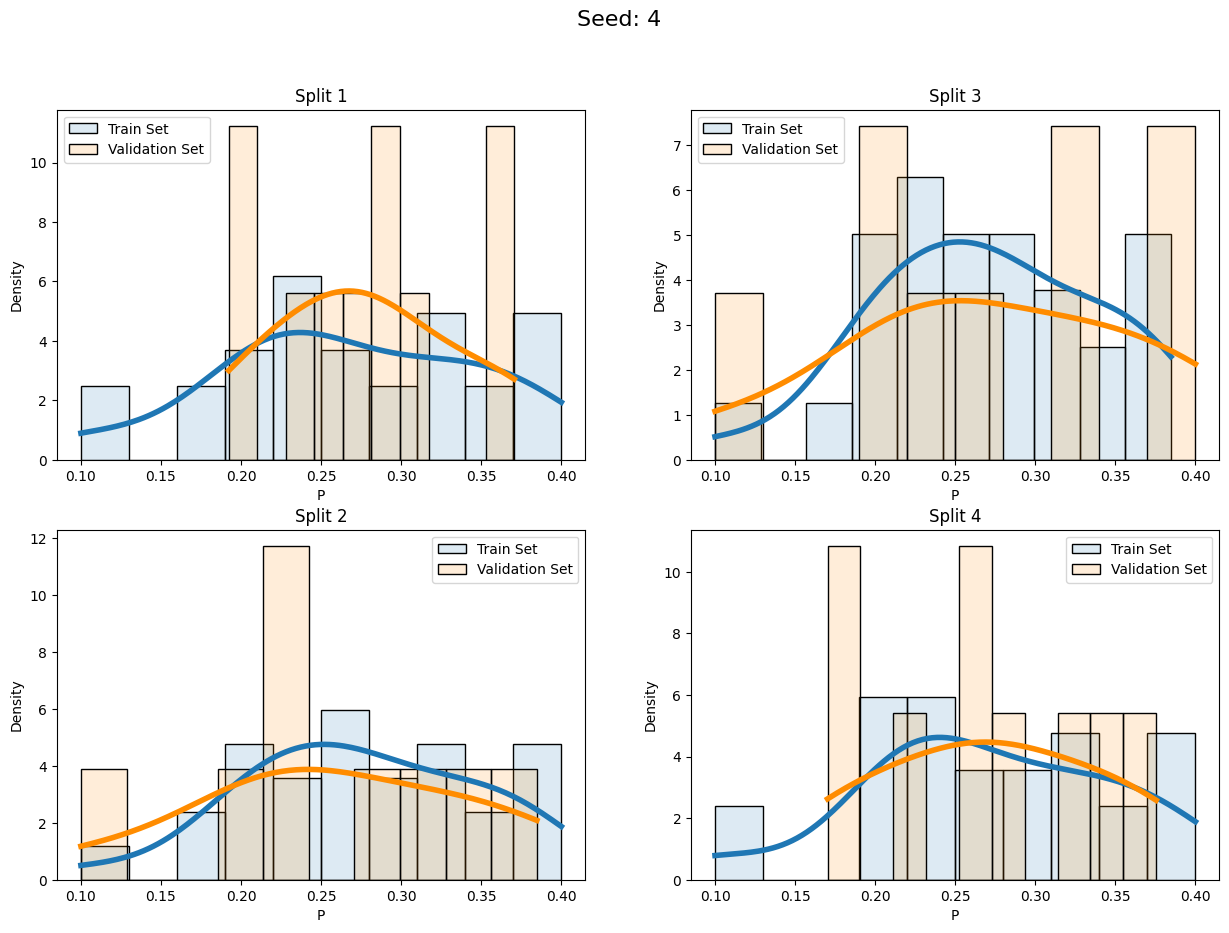

In [34]:
num_of_folds = 4
num_of_groups = 5

cv_splits = create_cont_folds(target, n_s=num_of_folds, n_grp=num_of_groups, seed=4)
fold_visualizer(data=target,
                fold_idxs=cv_splits,
                seed_num=4)

In [35]:
cv_splits = create_cont_folds(y, n_s=4, n_grp=5, seed=4)
x_tr = x.iloc[cv_splits[3][0]]
y_tr = y.iloc[cv_splits[3][0]]
x_te = x.iloc[cv_splits[3][1]]
y_te = y.iloc[cv_splits[3][1]]

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


# 9. Variable Selection

## 9.1. Boruta

In [36]:
%%capture
!pip install BorutaShap
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [37]:
import catboost as cb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from BorutaShap import BorutaShap, load_data
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from  sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

### Random Forest

In [38]:
selected_features = []

In [39]:
forest = RandomForestRegressor(
   n_jobs = -1, n_estimators=200
)

Feature_Selector = BorutaShap(model=forest,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_tr, y=y_tr, n_trials=100, random_state=0)

selected_features += Feature_Selector.accepted
selected_features += Feature_Selector.tentative

  0%|          | 0/100 [00:00<?, ?it/s]

7 attributes confirmed important: ['B5 B6 B7^2 ln(B3) 1/B1 1/ln(B7)', 'B5^2 ln(B4) 1/B4 1/B7 1/ln(B1)', 'ln(B5)^4 ln(B6) 1/B1 1/B6', 'B2^2 ln(B5) 1/B1^2 1/ln(B3) 1/ln(B4)', 'ln(B2)^2 ln(B5) ln(B6) 1/B7 1/ln(B1) 1/ln(B3)', 'B2 ln(B2)^2 ln(B6) 1/B1 1/B7 1/ln(B3)', 'B2 B6^2 1/B1 1/B7^2 1/ln(B3)']
7 attributes confirmed unimportant: ['B6 ln(B1) ln(B3) ln(B6) 1/B7^2 1/ln(B4)', 'B2 ln(B2)^2 1/B1 1/ln(B4)^2', 'B5 ln(B6)^2 1/B7^2 1/ln(B1) 1/ln(B3)', 'B4 B6 ln(B5) 1/B7^2 1/ln(B3)^2', 'ln(B2) ln(B6)^3 1/B7^2 1/ln(B4)', 'B3 B7 ln(B2) 1/B1 1/ln(B1) 1/ln(B4) 1/ln(B6)', 'B2 ln(B2)^2 1/ln(B1) 1/ln(B3) 1/ln(B6)']
1 tentative attributes remains: ['B2 B5 B6 1/B1 1/B7 1/ln(B6)^2']


### Gradient Boosting

In [40]:
gb = GradientBoostingRegressor(
   n_estimators=200
)

Feature_Selector = BorutaShap(model=gb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_tr, y=y_tr, n_trials=100, random_state=0)

selected_features += Feature_Selector.accepted
selected_features += Feature_Selector.tentative

  0%|          | 0/100 [00:00<?, ?it/s]

3 attributes confirmed important: ['B5 B6 B7^2 ln(B3) 1/B1 1/ln(B7)', 'ln(B5)^4 ln(B6) 1/B1 1/B6', 'B2 ln(B2)^2 ln(B6) 1/B1 1/B7 1/ln(B3)']
10 attributes confirmed unimportant: ['B6 ln(B1) ln(B3) ln(B6) 1/B7^2 1/ln(B4)', 'B2 ln(B2)^2 1/B1 1/ln(B4)^2', 'B5 ln(B6)^2 1/B7^2 1/ln(B1) 1/ln(B3)', 'B4 B6 ln(B5) 1/B7^2 1/ln(B3)^2', 'ln(B2) ln(B6)^3 1/B7^2 1/ln(B4)', 'B2 B6^2 1/B1 1/B7^2 1/ln(B3)', 'ln(B2)^2 ln(B5) ln(B6) 1/B7 1/ln(B1) 1/ln(B3)', 'B3 B7 ln(B2) 1/B1 1/ln(B1) 1/ln(B4) 1/ln(B6)', 'B2 ln(B2)^2 1/ln(B1) 1/ln(B3) 1/ln(B6)', 'B2 B5 B6 1/B1 1/B7 1/ln(B6)^2']
2 tentative attributes remains: ['B2^2 ln(B5) 1/B1^2 1/ln(B3) 1/ln(B4)', 'B5^2 ln(B4) 1/B4 1/B7 1/ln(B1)']


### CatBoost

In [41]:
ctb = CatBoostRegressor(iterations=200)

# no model selected default is Random Forest, if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=ctb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_tr, y=y_tr, n_trials=100, random_state=0)

selected_features += Feature_Selector.accepted
selected_features += Feature_Selector.tentative

  0%|          | 0/100 [00:00<?, ?it/s]

3 attributes confirmed important: ['B5 B6 B7^2 ln(B3) 1/B1 1/ln(B7)', 'ln(B5)^4 ln(B6) 1/B1 1/B6', 'B2 ln(B2)^2 ln(B6) 1/B1 1/B7 1/ln(B3)']
7 attributes confirmed unimportant: ['B2 ln(B2)^2 1/B1 1/ln(B4)^2', 'B5 ln(B6)^2 1/B7^2 1/ln(B1) 1/ln(B3)', 'B4 B6 ln(B5) 1/B7^2 1/ln(B3)^2', 'ln(B2) ln(B6)^3 1/B7^2 1/ln(B4)', 'ln(B2)^2 ln(B5) ln(B6) 1/B7 1/ln(B1) 1/ln(B3)', 'B3 B7 ln(B2) 1/B1 1/ln(B1) 1/ln(B4) 1/ln(B6)', 'B2 ln(B2)^2 1/ln(B1) 1/ln(B3) 1/ln(B6)']
5 tentative attributes remains: ['B5^2 ln(B4) 1/B4 1/B7 1/ln(B1)', 'B6 ln(B1) ln(B3) ln(B6) 1/B7^2 1/ln(B4)', 'B2^2 ln(B5) 1/B1^2 1/ln(B3) 1/ln(B4)', 'B2 B6^2 1/B1 1/B7^2 1/ln(B3)', 'B2 B5 B6 1/B1 1/B7 1/ln(B6)^2']


### XGBoost

In [42]:
xgb = XGBRegressor(n_estimators=200)

# no model selected default is Random Forest, if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=xgb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_tr, y=y_tr, n_trials=100, random_state=0)

selected_features += Feature_Selector.accepted
selected_features += Feature_Selector.tentative

  0%|          | 0/100 [00:00<?, ?it/s]

3 attributes confirmed important: ['B5 B6 B7^2 ln(B3) 1/B1 1/ln(B7)', 'ln(B5)^4 ln(B6) 1/B1 1/B6', 'B2 ln(B2)^2 ln(B6) 1/B1 1/B7 1/ln(B3)']
12 attributes confirmed unimportant: ['B5^2 ln(B4) 1/B4 1/B7 1/ln(B1)', 'B6 ln(B1) ln(B3) ln(B6) 1/B7^2 1/ln(B4)', 'B2 ln(B2)^2 1/B1 1/ln(B4)^2', 'B5 ln(B6)^2 1/B7^2 1/ln(B1) 1/ln(B3)', 'B4 B6 ln(B5) 1/B7^2 1/ln(B3)^2', 'ln(B2) ln(B6)^3 1/B7^2 1/ln(B4)', 'B2^2 ln(B5) 1/B1^2 1/ln(B3) 1/ln(B4)', 'ln(B2)^2 ln(B5) ln(B6) 1/B7 1/ln(B1) 1/ln(B3)', 'B2 B6^2 1/B1 1/B7^2 1/ln(B3)', 'B3 B7 ln(B2) 1/B1 1/ln(B1) 1/ln(B4) 1/ln(B6)', 'B2 ln(B2)^2 1/ln(B1) 1/ln(B3) 1/ln(B6)', 'B2 B5 B6 1/B1 1/B7 1/ln(B6)^2']
0 tentative attributes remains: []


In [43]:
selected_features = list(dict.fromkeys(selected_features))

x_tr = x_tr[selected_features]
x_te = x_te[selected_features]
df = x[selected_features].copy()
df['P'] = y

In [44]:
eigenvectors = pca.components_
eigenvectors = [eigenvectors[1]]
variables = poly_df.columns  # Adjust this based on your actual variable names

for i, comp in enumerate(eigenvectors):
    terms = [f"{comp[j]:.3f}*{variables[j]}" for j in range(len(variables)) if round(comp[j],3) != 0]
    formula = " + ".join(terms)
    print(f"Principal Component {i+1}: {formula}")

NameError: name 'pca' is not defined

# 10. Bivariate analysis / correlation between data

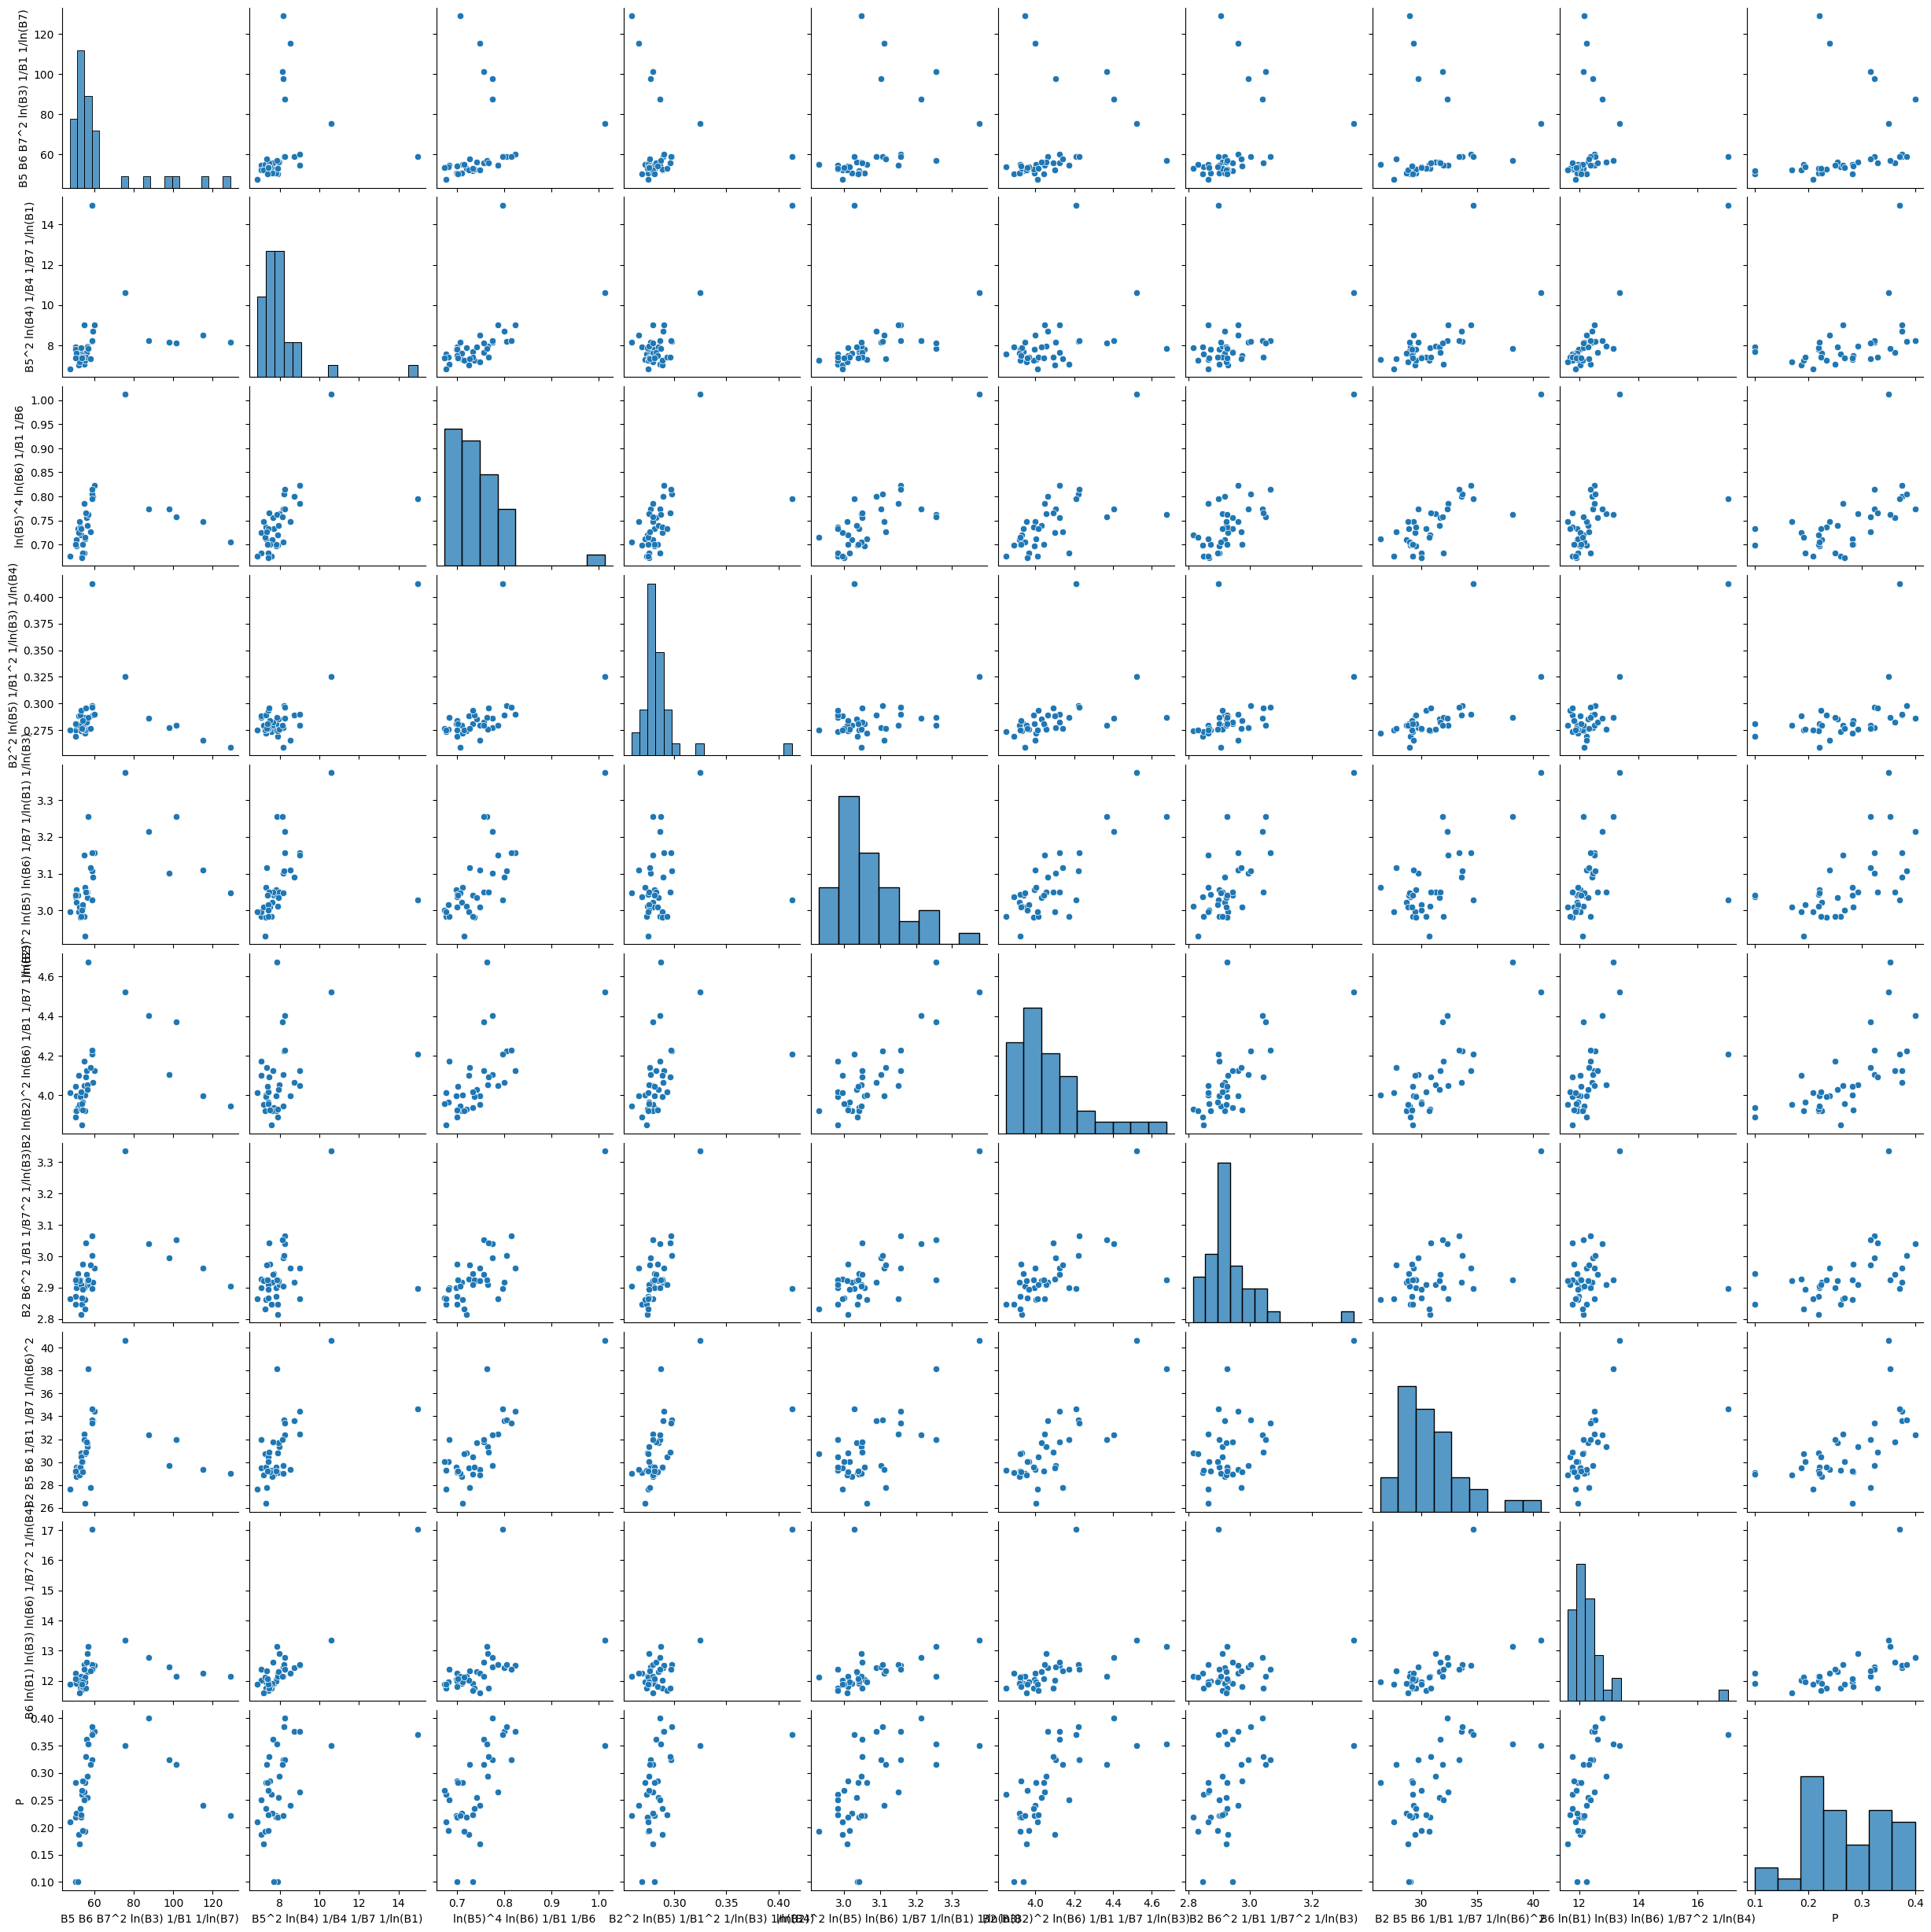

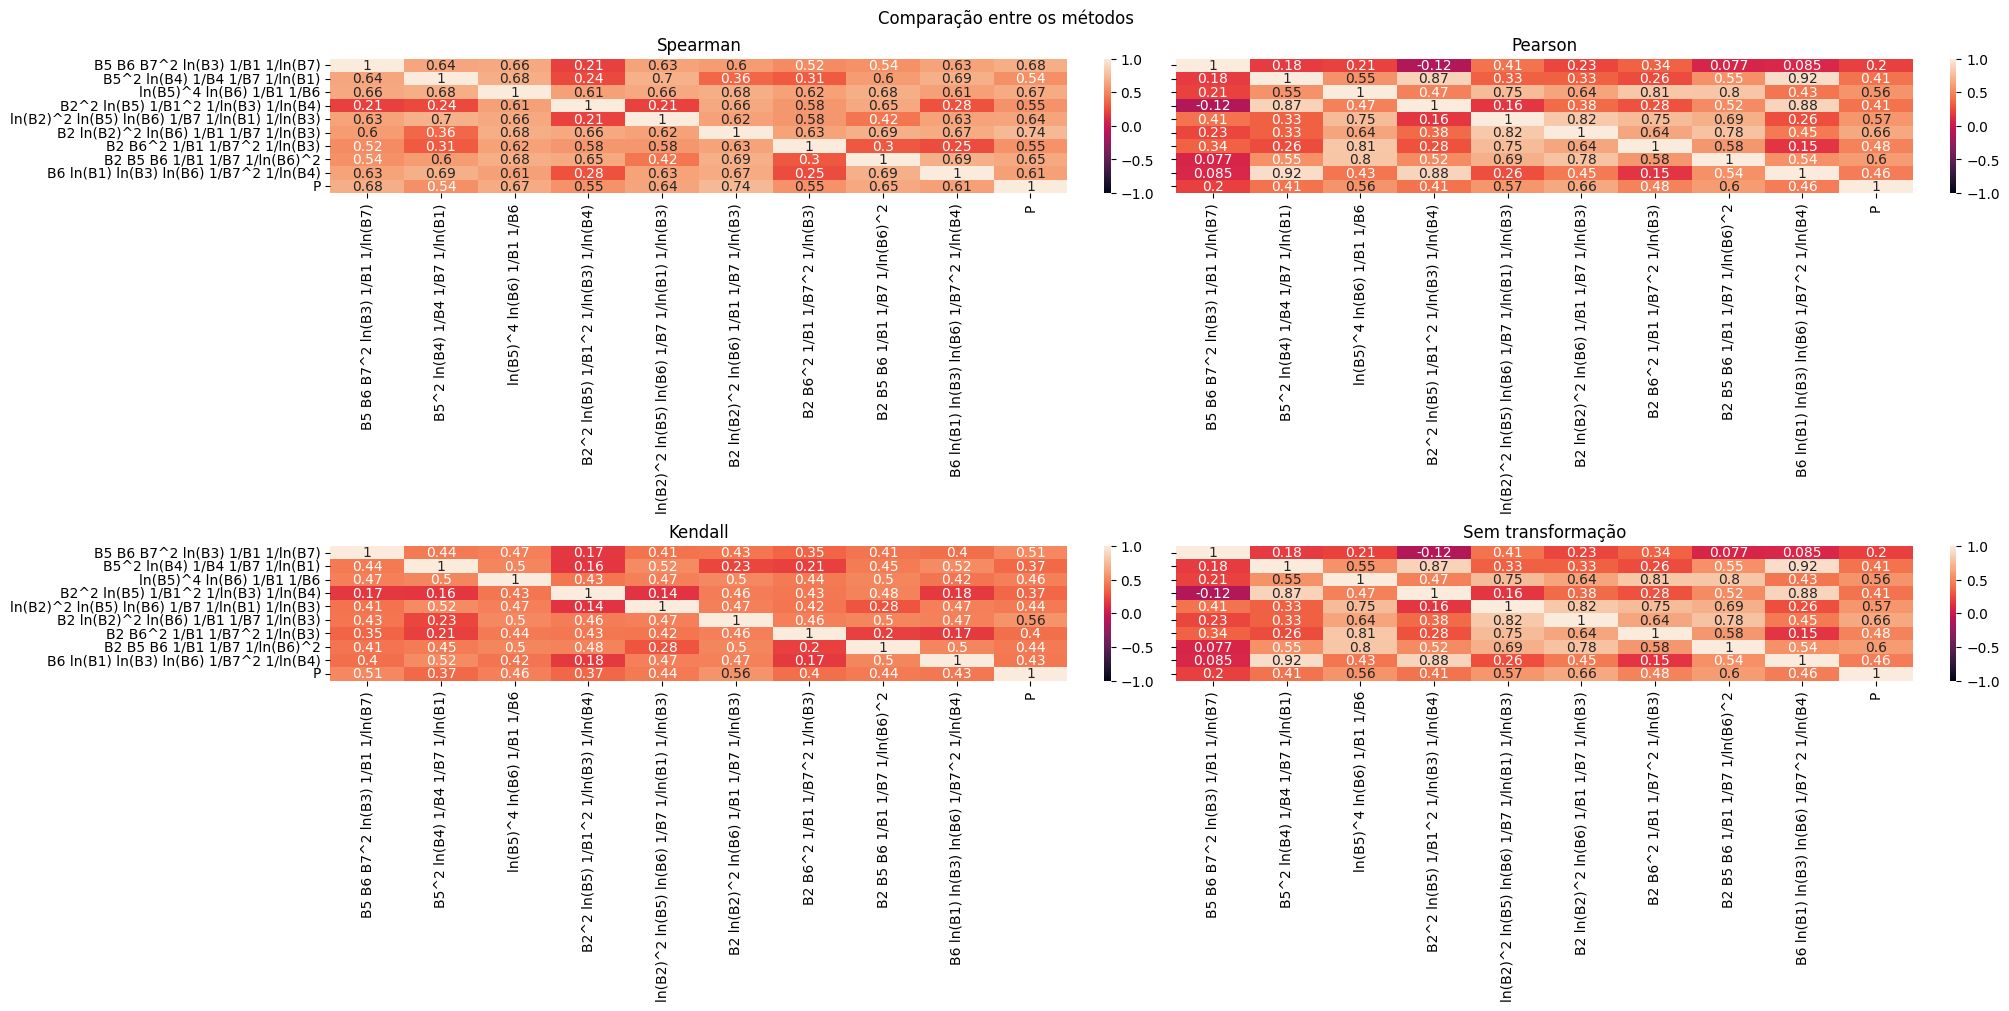

In [45]:
sns.pairplot(df)
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True, constrained_layout=True)
fig.suptitle('Comparação entre os métodos')

#Spearman
ax = sns.heatmap(df.corr(method='spearman'), annot=True, vmin=-1, vmax=1, ax = axes[0,0])
axes[0,0].set_title("Spearman")
bottom, top = ax.get_ylim()

#Pearson
ax = sns.heatmap(df.corr(method='pearson'), annot=True, vmin=-1, vmax=1, ax = axes[0,1])
axes[0,1].set_title("Pearson")
bottom, top = ax.get_ylim()

#Kendall
ax = sns.heatmap(df.corr(method='kendall'), annot=True, vmin=-1, vmax=1, ax = axes[1,0])
bottom, top = ax.get_ylim()
axes[1,0].set_title("Kendall")

#Sem transformação
ax = sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, ax = axes[1,1])
axes[1,1].set_title("Sem transformação")
bottom, top = ax.get_ylim()

# 11. Regression Algorithms

In [46]:
def plot_results(y_pred, y_tes):
  plt.rcParams["figure.figsize"] = (10,5)
  plt.scatter(range(len(y_pred)), y_pred, c='r')
  plt.plot(range(len(y_tes)), y_tes, linestyle="-", marker="o", label="Expenses")
  plt.title('Model performance - test set')
  plt.ylabel('P medido')
  plt.xlabel('Sample')
  plt.legend(['predicted', 'real'], loc='upper left')
  plt.show()

Before we implement the regression models, I would like to clarify that we will use two main metrics to evaluate the performance of our models:


  * Mean Absolute Percentage Error (MAPE):
  \begin{equation}
    MAPE = \frac{1}{n} \sum_{i = 1}^{n} \frac{|y_i - p_i|}{y_i}
  \end{equation}

  * Mean Absolute Error (MAE):
  \begin{equation}
    MAE = \frac{1}{n} \sum_{i = 1}^{n} |y_i - p_i|
  \end{equation}

  * $R^2$ score:
  \begin{equation}
    R^2 = NSE = 1 - \frac{\sum_{i=1}^{N} (y_i - p_i)^2}{\sum_{i=1}^{N} (y_i - \bar{y_i})^2}
  \end{equation}


Where $y_i$ is the actual value, $p_i$ is the value predicted by the tested model, and $\bar{y_i}$ is the average of the $y_i$ values, $\forall i$.


## 11.1. Linear Methods

In [47]:
import sklearn.model_selection as skms
import sklearn.linear_model as sklm
import sklearn as sk
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.metrics import make_scorer

In [48]:
def inverse_box_cox(y, lambda_):
  if lambda_ == 0:
    return np.exp(y)
  else:
    return np.log(1 + lambda_*y)/np.log(lambda_)

def inverse_square_root(y):
  return y**2

In [49]:
def cross_validation(x_train, y_train, folds, lambda_=None):

  splits = create_cont_folds(y_train, n_s=folds, n_grp=10, seed=4)
  x_tr = np.array(x_train)
  y_tr = np.array(y_train)
  histories = []
  models = []
  results = []


  for train_index, test_index in splits:
    xtr, xva = x_tr[train_index], x_tr[test_index]
    ytr, yva = y_tr[train_index], y_tr[test_index]

    model = sklm.LinearRegression()
    model.fit(xtr, ytr)
    y_pred = model.predict(xva)

    if lambda_ !=None:
      y_pred = inverse_square_root(y_pred)
      yva = inverse_square_root(yva)


    r2 = r2_score(yva, y_pred)
    mae = mean_absolute_error(yva, y_pred)
    mape = mean_absolute_percentage_error(yva, y_pred)
    mse = mean_squared_error(yva, y_pred)
    result = {'r2':r2, 'mae':mae, 'mape':mape, 'mse':mse}
    results.append(result)

  return results

In [50]:
def train_test_model(model, x_tr, y_tr, x_te, y_te, lambda_=None, folds=5):
  scores = cross_validation(x_tr, y_tr, folds=folds, lambda_=lambda_)

  mae = np.mean([val['mae'] for val in scores])
  std_mae = np.std([val['mae'] for val in scores])

  mape = np.mean([val['mape'] for val in scores])
  std_mape = np.std([val['mape'] for val in scores])

  mse = np.mean([val['mse'] for val in scores])
  std_mse = np.std([val['mse'] for val in scores])

  r2 = np.mean([val['r2'] for val in scores])
  std_r2 = np.std([val['r2'] for val in scores])

  print('--------------------Validação Cruazada-----------------------')
  print("Média dos valore de MAE: " + str(mae))
  print("Desvio padrão dos valore de MAE: " + str(std_mae) + "\n")

  print("Média dos valore de MAPE: " + str(mape))
  print("Desvio padrão dos valore de MAPE: " + str(std_mape) + "\n")

  print("Média dos valore de MSE: " + str(mse))
  print("Desvio padrão dos valore de MSE: " + str(std_mse) + "\n")

  print("Média dos valore de R2: " + str(r2))
  print("Desvio padrão dos valore de R2: " + str(std_r2) + "\n")

  print('--------------------Teste-----------------------')
  model.fit(x_tr, y_tr)
  y_pred = model.predict(x_te)

  if lambda_ !=None:
      y_pred = inverse_square_root(y_pred)
      y_te = inverse_square_root(y_te)

  print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
  print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
  print("MSE: " + str(mean_squared_error(y_te, y_pred)))
  print("R2: " + str(r2_score(y_te, y_pred)))

  plot_results(y_pred, y_te)

### 11.2.1. Linear Regression

**Using only train set**

--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 3.650781561738737
Desvio padrão dos valore de MAE: 7.180487095621375

Média dos valore de MAPE: 27.02481309180713
Desvio padrão dos valore de MAPE: 52.14155226513137

Média dos valore de MSE: 452.56083700406145
Desvio padrão dos valore de MSE: 905.0942353736665

Média dos valore de R2: -396165.766209717
Desvio padrão dos valore de R2: 792317.4774926188

--------------------Teste-----------------------
MAE: 0.016836697475368853
MAPE: 0.37845191234729764
MSE: 0.0004465843674026695
R2: 0.7154642380119036


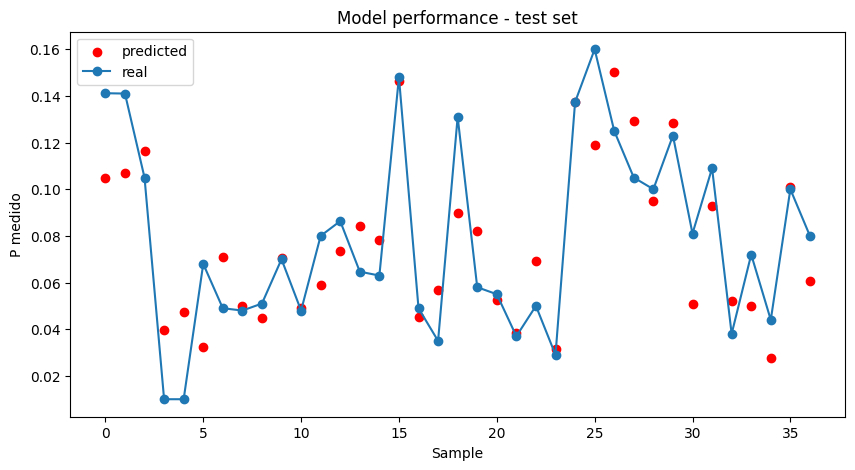

In [51]:
linear_regressor = sklm.LinearRegression()
train_test_model(linear_regressor, x, y, x, y, lambda_=0, folds=5)

**Using train and test sets**

--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.04532870276266108
Desvio padrão dos valore de MAE: 0.028308438146020572

Média dos valore de MAPE: 0.6862463848538785
Desvio padrão dos valore de MAPE: 0.19404852869768077

Média dos valore de MSE: 0.010907054763445237
Desvio padrão dos valore de MSE: 0.0167487172909005

Média dos valore de R2: -7.1917304139964
Desvio padrão dos valore de R2: 12.923505706482947

--------------------Teste-----------------------
MAE: 0.045075935682406844
MAPE: 0.6328558633569054
MSE: 0.0034130600434255417
R2: -1.5546384475546482


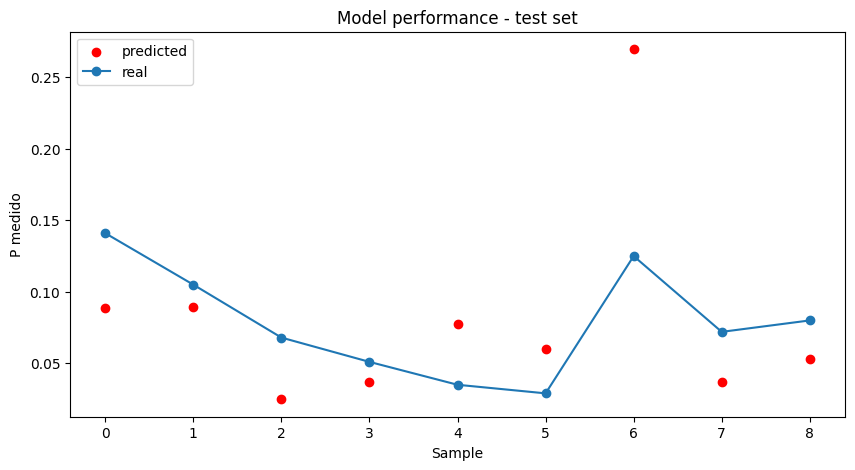

In [52]:
linear_regressor = sklm.LinearRegression()
train_test_model(linear_regressor, x_tr, y_tr, x_te, y_te, lambda_=0, folds=4)

In [53]:
print("Coeficientes da regressão linear: " + str(linear_regressor.coef_))

Coeficientes da regressão linear: [ 8.15994365e-03 -5.89515315e-01  9.33307900e-01  2.14370327e+01
  4.53549090e+00 -2.22718106e+00 -1.86512141e+00  4.17938062e-02
  3.60544340e-01]


In [54]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 9.4 MB/s eta 0:00:00


In [55]:
from pygam import LinearGAM, s, l

--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 3.650781561738737
Desvio padrão dos valore de MAE: 7.180487095621375

Média dos valore de MAPE: 27.02481309180713
Desvio padrão dos valore de MAPE: 52.14155226513137

Média dos valore de MSE: 452.56083700406145
Desvio padrão dos valore de MSE: 905.0942353736665

Média dos valore de R2: -396165.766209717
Desvio padrão dos valore de R2: 792317.4774926188

--------------------Teste-----------------------
MAE: 0.03272786563137982
MAPE: 0.7146806169759599
MSE: 0.001566671946385422
R2: 0.001814150721914931


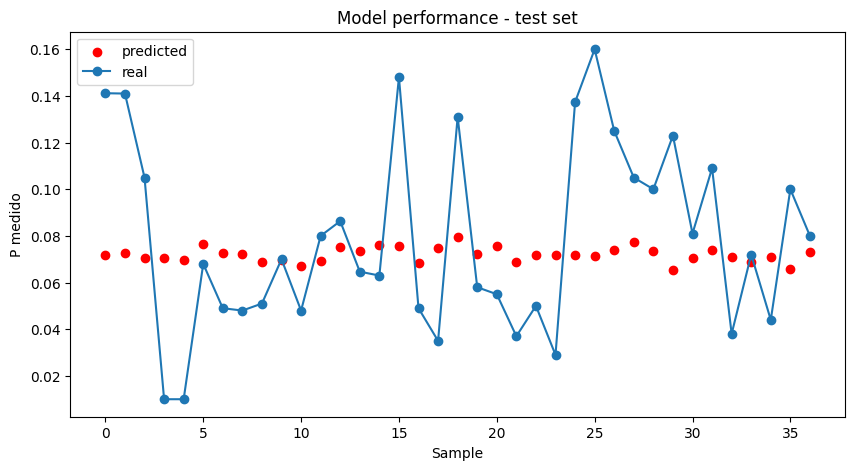

In [56]:
gam = LinearGAM(s(0, n_splines=500)+s(1, n_splines=500)+s(2, n_splines=500)+s(3, n_splines=500)+s(4, n_splines=500)+s(5, n_splines=500)+s(6, n_splines=500)+s(7, n_splines=500)+s(8, n_splines=500), constraints='none')
train_test_model(gam, x, y, x, y, lambda_=0, folds=5)

In [57]:
x

,B2 ln(B2)^2 ln(B6) 1/B1 1/B7 1/ln(B3),B5 B6 B7^2 ln(B3) 1/B1 1/ln(B7),ln(B5)^4 ln(B6) 1/B1 1/B6,B2 B5 B6 1/B1 1/B7 1/ln(B6)^2,ln(B2)^2 ln(B5) ln(B6) 1/B7 1/ln(B1) 1/ln(B3),B6 ln(B1) ln(B3) ln(B6) 1/B7^2 1/ln(B4),ln(B2) ln(B6)^3 1/B7^2 1/ln(B4),B4 B6 ln(B5) 1/B7^2 1/ln(B3)^2,B2 B6^2 1/B1 1/B7^2 1/ln(B3),B2^2 ln(B5) 1/B1^2 1/ln(B3) 1/ln(B4),B5^2 ln(B4) 1/B4 1/B7 1/ln(B1),B3 B7 ln(B2) 1/B1 1/ln(B1) 1/ln(B4) 1/ln(B6),B2 ln(B2)^2 1/ln(B1) 1/ln(B3) 1/ln(B6),B5 ln(B6)^2 1/B7^2 1/ln(B1) 1/ln(B3),B2 ln(B2)^2 1/B1 1/ln(B4)^2
0,4.063164,58.968021,0.799853,33.642732,3.090788,12.431180,1.656554,15.486323,2.918330,0.289396,8.704256,0.364062,24.536749,1.681482,1.210728
1,4.123705,59.923297,0.823160,34.469477,3.157151,12.503850,1.676455,16.265995,2.961435,0.290204,9.017758,0.353055,24.884300,1.746467,1.198523
2,4.102941,97.886744,0.774698,29.726524,3.102252,12.449019,1.686331,15.325775,2.993734,0.277184,8.175753,0.391340,27.733357,1.554027,1.204404
3,3.889086,50.412897,0.698697,29.070541,3.037284,12.238180,1.676002,14.625040,2.846833,0.269382,7.904921,0.309585,23.934411,1.597424,1.189545
4,3.937415,51.607176,0.733118,28.920585,3.041150,11.921522,1.668181,14.949242,2.943680,0.281276,7.698990,0.323906,23.087713,1.616535,1.178922
5,3.847625,53.559214,0.676018,29.272670,2.984113,11.765618,1.600682,14.742622,2.847842,0.273274,7.569602,0.304431,23.702343,1.557548,1.184490
6,3.995219,50.483918,0.697825,29.571591,3.057452,12.041563,1.661171,14.711979,2.899025,0.281188,7.788411,0.310334,24.525806,1.587777,1.219016
7,3.922138,50.442263,0.699569,29.192676,3.042714,11.992838,1.653806,14.810039,2.871400,0.274940,7.794122,0.306411,24.034767,1.594227,1.192750
8,3.919468,50.803659,0.710087,28.723209,3.021665,11.917900,1.658914,14.677107,2.917852,0.279581,7.605755,0.318826,23.276729,1.589512,1.189649
9,4.047825,54.558067,0.785578,32.414878,3.150770,12.524647,1.697351,15.411415,2.864291,0.279688,9.020318,0.330128,25.283189,1.706850,1.207117


### 11.2.2. Ridge Regression

In [ ]:
ray.init()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
# definindo espaço de busca para os lambdas
lambdas = np.linspace(0, 1000000, 10000)

**5-Folds**

In [ ]:
@ray.remote

def test_lambda(lamb):
  # aplicando a regressão
  ridge = sklm.Ridge(alpha = lamb)
  ridge.fit(x_tr, y_tr)             # Fit a ridge regression on the training data

  scores = skms.cross_validate(ridge, x_tr, y_tr, cv=5,
                               scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'))

  mae = np.mean(scores['test_neg_mean_absolute_error']*(-1))
  mape = np.mean(scores['test_neg_mean_absolute_percentage_error']*(-1))
  r2 = np.mean(scores['test_r2'])

  return [mae, mape, r2]

In [ ]:
result_values = ray.get([test_lambda.remote(i) for i in lambdas])
scores_MAE = [result[0] for result in result_values]
scores_MAPE = [result[1] for result in result_values]
scores_R2 = [result[2] for result in result_values]

In [ ]:
best_index = scores_MAE.index(min(scores_MAE))

print("Lambda:" + str(lambdas[best_index]))
print("Best MAE: " + str(scores_MAE[best_index]))
print("Best MAPE: " + str(scores_MAPE[best_index]))
print("R2: " + str(scores_R2[best_index]))

ridge = sklm.Ridge(alpha = lambdas[best_index])
ridge.fit(x_tr, y_tr)
plot_results(ridge.predict(x_te), y_te)

**10-folds**

In [ ]:
@ray.remote

def test_lambda(lamb):
  # aplicando a regressão
  ridge = sklm.Ridge(alpha = lamb)
  ridge.fit(x_tr, y_tr)             # Fit a ridge regression on the training data

  scores = skms.cross_validate(ridge, x_tr, y_tr, cv=10,
                               scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'))

  mae = np.mean(scores['test_neg_mean_absolute_error']*(-1))
  mape = np.mean(scores['test_neg_mean_absolute_percentage_error']*(-1))
  r2 = np.mean(scores['test_r2'])

  return [mae, mape, r2]

In [ ]:
result_values = ray.get([test_lambda.remote(i) for i in lambdas])
scores_MAE = [result[0] for result in result_values]
scores_MAPE = [result[1] for result in result_values]
scores_R2 = [result[2] for result in result_values]

In [ ]:
best_index = scores_MAE.index(min(scores_MAE))

print("Lambda:" + str(lambdas[best_index]))
print("Best MAE: " + str(scores_MAE[best_index]))
print("Best MAPE: " + str(scores_MAPE[best_index]))
print("R2: " + str(scores_R2[best_index]))

ridge = sklm.Ridge(alpha = lambdas[best_index])
ridge.fit(x_tr, y_tr)
plot_results(ridge.predict(x_te), y_te)

In [ ]:
y_pred = ridge.predict(x_te)
print('-----------Teste-------------')
print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
print("R2: " + str(r2_score(y_te, y_pred)))

## 11.2 Non-linear Methods

### 11.2.1. SVM

In [ ]:
from sklearn import svm

**5-Folds**

In [ ]:
svm_regressor = svm.SVR()
train_test_model(svm_regressor, x_tr, y_tr, x_te, y_te, folds=5)

**10-Folds**

In [ ]:
train_test_model(svm_regressor, x_tr, y_tr, x_te, y_te, folds=10)

### 11.2.2. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor as rf

In [ ]:
rf_regressor = rf(n_estimators=1000, random_state=1)
rf_regressor.fit(x_tr, y_tr)

**5-Folds**

In [ ]:
train_test_model(rf_regressor, x_tr, y_tr, x_te, y_te, folds=5)

**10-Folds**

In [ ]:
train_test_model(rf_regressor, x_tr, y_tr, x_te, y_te, folds=10)

### 11.2.3 Gradient Boost

In [ ]:
import catboost as cb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from  sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [ ]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [2, 3, 5, 7, 10],
        'min_samples_split': [2, 5, 10, 20],
        'max_features': ['log2', 0.25, 'sqrt', 1.0],
        'subsample': [0.15, 0.5, 0.75, 1.0]}

clf = GridSearchCV(GradientBoostingRegressor(n_estimators=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_tr)
clf.best_params_

In [ ]:
gb = GradientBoostingRegressor(n_estimators=200,learning_rate=0.025,
 max_depth=3,
 max_features='log2',
 min_samples_split=2,
 subsample=0.15
)


train_test_model(gb, x_tr, y_tr, x_te, y_te, folds=10)

### 11.2.4 CatBoost

In [ ]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [3, 6, 9],
        'leaf_estimation_iterations': [1, 10],
        'l2_leaf_reg': [1, 3, 6, 9]}

clf = GridSearchCV(CatBoostRegressor(iterations=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_tr)
clf.best_params_

In [ ]:
ctb = CatBoostRegressor(n_estimators=200,l2_leaf_reg= 1,
 leaf_estimation_iterations= 10,
 learning_rate= 0.3,
 max_depth= 6)


train_test_model(ctb, x_tr, y_tr, x_te, y_te, folds=10)

In [ ]:
ctb.get_feature_importance(prettified=True)

### 11.2.5 XGBoost

In [ ]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [2, 3, 5, 7, 10, 100],
        'gamma':[0, 0.1, 0.2, 0.3, 0.4, 1.0, 1.5, 2.0],
        'colsample_bylevel': ['log2', 'sqrt', 0.25, 1.0],
        'subsample': [0.15, 0.5, 0.75, 1.0]}

clf = GridSearchCV(XGBRegressor(n_estimators=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_tr)
clf.best_params_

In [ ]:
xgb = XGBRegressor(n_estimators=200,colsample_bylevel=0.25,
 gamma=0,
 learning_rate=0.025,
 max_depth=10,
 subsample=0.15
)


train_test_model(ctb, x_tr, y_tr, x_te, y_te, folds=10)

In [ ]:
%%capture
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%writefile no_code.tpl
{% extends 'article.tplx' %}

{% block input_group %}
{% endblock input_group %}

In [ ]:
!cp /content/drive/MyDrive/CNN_Chagas/fosforo/Cópia_de_Analise_fosforo.ipynb ./

In [ ]:
!jupyter nbconvert --to pdf  "Cópia_de_Analise_fosforo.ipynb"